In [1]:
import os
import numpy as np
import pandas as pd
import glob
from tqdm.auto import tqdm

import torch
import torchaudio

from sklearn.model_selection    import train_test_split
from sklearn.preprocessing      import StandardScaler
from sklearn.pipeline           import Pipeline
from sklearn.ensemble           import RandomForestClassifier
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.svm                import SVC
from sklearn.semi_supervised    import LabelPropagation
from sklearn.metrics            import classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

DEVICE         = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_CSV       = './Data/data_labeled_filtered.csv'
AUDIO_ROOT     = './Data/Audio'
SAMPLES_PER_LABEL = 15000
N_MFCC         = 40
N_MELS         = 64
TEST_SIZE      = 0.2
RANDOM_STATE   = 42

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv(DATA_CSV)

display(df.head())
print("Per‐class counts:\n", df['label'].value_counts())

,path,sentence,up_votes,down_votes,age,gender,accent,label,source
0,common_voice_en_19687170.mp3,He associated with the Formists.,2,1,0,0,us,3,Audio
1,common_voice_en_19687171.mp3,"The ""ultra accelerator"" injection gives Derric...",2,1,0,0,us,3,Audio
2,common_voice_en_19687172.mp3,"Despite running as a joke, candidates have won...",2,0,0,0,us,3,Audio
3,common_voice_en_19687173.mp3,Stoner also guest-starred in the television dr...,2,0,0,0,us,3,Audio
4,common_voice_en_19687174.mp3,Rainelle was named for the Raine family.,2,0,0,0,us,3,Audio


Per‐class counts:
 0    119700
1     19341
2     17292
3     15825
Name: label, dtype: int64


In [3]:
n_fft      = 512
hop_length = 256
n_mels     = 64

melspec_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=16000,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels,
).to(DEVICE)

mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=16000,
    n_mfcc=N_MFCC,
    melkwargs={
        'n_fft':       n_fft,
        'hop_length':  hop_length,
        'n_mels':      n_mels,
    }
).to(DEVICE)

In [ ]:
features, labels = [], []
for row in tqdm(df.itertuples(index=False), total=len(df), desc="Extracting"):
    path = os.path.join(AUDIO_ROOT, row.path)
    waveform, sr = torchaudio.load(path)
    waveform = waveform.to(DEVICE)

    waveform = torch.where(waveform.abs() < 1e-4,
                           torch.zeros_like(waveform),
                           waveform)

    # 1) MFCC: [1, N_MFCC, T']
    mfcc = mfcc_transform(waveform)
    # 2) MelSpectrogram: [1, N_MELS, T']
    melspec = melspec_transform(waveform)

    # collapse time → mean & var vectors
    mfcc_mean = mfcc.mean(dim=2).squeeze(0)  # [N_MFCC]
    mfcc_var  = mfcc.var(dim=2).squeeze(0)
    spec_mean = melspec.mean(dim=2).squeeze(0)  # [N_MELS]
    spec_var  = melspec.var(dim=2).squeeze(0)

    feat = torch.cat([mfcc_mean, mfcc_var, spec_mean, spec_var], dim=0)
    features.append(feat.cpu().numpy())
    labels.append(row.age)

X = np.vstack(features)
y = np.array(labels)
print("X shape:", X.shape, "y shape:", y.shape)

Extracting: 100%|██████████| 172158/172158 [50:08<00:00, 57.23it/s] 


X shape: (172158, 208) y shape: (172158,)


In [26]:
def export_features_to_csv(X, df, output_path='./Data/data_with_features.csv'):
    feature_columns = []
    
    for i in range(N_MFCC):
        feature_columns.append(f'mfcc_mean_{i}')
    for i in range(N_MFCC):
        feature_columns.append(f'mfcc_var_{i}')
    for i in range(N_MELS):
        feature_columns.append(f'melspec_mean_{i}')
    for i in range(N_MELS):
        feature_columns.append(f'melspec_var_{i}')
    
    df_features = pd.DataFrame(X, columns=feature_columns)
    
    if len(df) != len(df_features):
        raise ValueError(f"Length mismatch: df has {len(df)} rows but features has {len(df_features)} rows")
    
    df_combined = pd.concat([df.reset_index(drop=True), 
                           df_features.reset_index(drop=True)], axis=1)
    
    df_combined.to_csv(output_path, index=False)
    print(f"Features exported to {output_path}")
    print(f"Original columns: {len(df.columns)}")
    print(f"Added feature columns: {len(df_features.columns)}")
    print(f"Total columns in output: {len(df_combined.columns)}")
    
    return df_combined

df_with_features = export_features_to_csv(X, df)

Features exported to ./Data/data_with_features.csv
Original columns: 9
Added feature columns: 208
Total columns in output: 217


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=RANDOM_STATE
)

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, svd_solver='full')   # keep 95% of variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)

In [7]:
from sklearn.model_selection    import train_test_split, GridSearchCV
from sklearn.preprocessing      import StandardScaler
from sklearn.feature_selection  import SelectKBest, f_classif
from sklearn.decomposition      import PCA
from sklearn.pipeline           import Pipeline
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.metrics            import classification_report, confusion_matrix
import matplotlib.pyplot        as plt
import seaborn                  as sns

# 6) Define three pipelines
pipelines = {
    'KNN_baseline': Pipeline([
        ('scaler', StandardScaler()),
        ('knn',    KNeighborsClassifier())
    ]),
    'KNN_selectK': Pipeline([
        ('scaler', StandardScaler()),
        ('kbest',  SelectKBest(score_func=f_classif, k=100)),
        ('knn',    KNeighborsClassifier())
    ]),
    'KNN_pca': Pipeline([
        ('scaler', StandardScaler()),
        ('pca',    PCA(n_components=0.95, svd_solver='full')),
        ('knn',    KNeighborsClassifier())
    ]),
}

# 7) Light grid over k in [3,5,7,9]
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9]
}

best_models = {}
for name, pipe in pipelines.items():
    print(f"\n=== Tuning {name} ===")
    # We only tune the 'knn' step in each pipeline
    grid = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    print(" Best k:", grid.best_params_['knn__n_neighbors'],
          "| CV acc:", f"{grid.best_score_:.4f}")
    best_models[name] = grid.best_estimator_


=== Tuning KNN_baseline ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
 Best k: 3 | CV acc: 0.9760

=== Tuning KNN_selectK ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
 Best k: 3 | CV acc: 0.9742

=== Tuning KNN_pca ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
 Best k: 3 | CV acc: 0.9765



--- Test results for KNN_baseline ---
              precision    recall  f1-score   support

         50s     0.9548    0.9576    0.9562      6623
         20s     0.9899    0.9892    0.9896     27809

    accuracy                         0.9831     34432
   macro avg     0.9724    0.9734    0.9729     34432
weighted avg     0.9831    0.9831    0.9831     34432



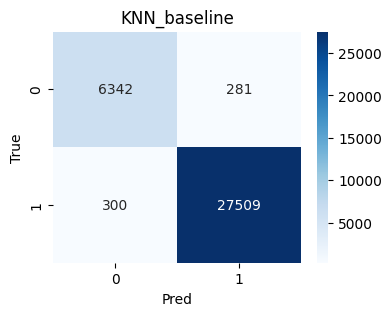


--- Test results for KNN_selectK ---
              precision    recall  f1-score   support

         50s     0.9489    0.9505    0.9497      6623
         20s     0.9882    0.9878    0.9880     27809

    accuracy                         0.9806     34432
   macro avg     0.9686    0.9691    0.9688     34432
weighted avg     0.9806    0.9806    0.9806     34432



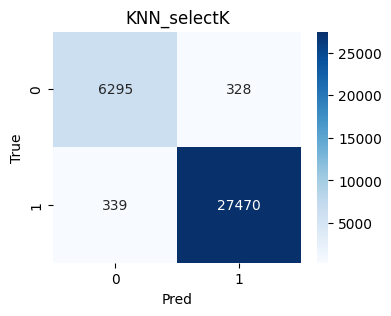


--- Test results for KNN_pca ---
              precision    recall  f1-score   support

         50s     0.9522    0.9570    0.9546      6623
         20s     0.9897    0.9886    0.9892     27809

    accuracy                         0.9825     34432
   macro avg     0.9710    0.9728    0.9719     34432
weighted avg     0.9825    0.9825    0.9825     34432



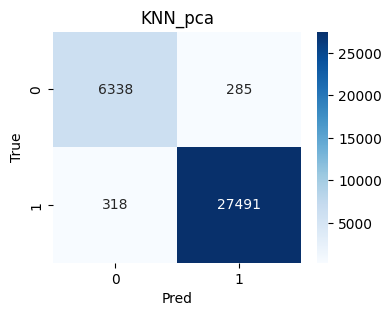

In [8]:
# 8) Evaluate all three
for name, model in best_models.items():
    print(f"\n--- Test results for {name} ---")
    y_pred = model.predict(X_test)
    print(classification_report(
        y_test, y_pred,
        target_names=['50s', '20s'],
        digits=4
    ))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[0,1], yticklabels=[0,1])
    plt.title(name)
    plt.xlabel('Pred'); plt.ylabel('True')
    plt.show()

In [9]:
from joblib import dump
# 9) Save the best model
best_model = best_models['KNN_baseline']
dump(best_model, 'KNN_baseline_age.joblib')

['KNN_baseline_age.joblib']

## Trial 2:

In [10]:
gender_map = {0: 'female', 1: 'male'}

In [11]:
print("Gender counts:\n", df['gender'].value_counts())
display(df.head())

Gender counts:
 1    136992
0     35166
Name: gender, dtype: int64


,path,sentence,up_votes,down_votes,age,gender,accent,label,source
0,common_voice_en_19687170.mp3,He associated with the Formists.,2,1,0,0,us,3,Audio
1,common_voice_en_19687171.mp3,"The ""ultra accelerator"" injection gives Derric...",2,1,0,0,us,3,Audio
2,common_voice_en_19687172.mp3,"Despite running as a joke, candidates have won...",2,0,0,0,us,3,Audio
3,common_voice_en_19687173.mp3,Stoner also guest-starred in the television dr...,2,0,0,0,us,3,Audio
4,common_voice_en_19687174.mp3,Rainelle was named for the Raine family.,2,0,0,0,us,3,Audio


In [12]:
y_gender = df['gender'].values
assert len(X) == len(y) == len(y_gender), "Mismatch in feature/label lengths!"

In [13]:
female_mask = (y_gender == 0)
male_mask   = (y_gender == 1)

In [14]:
X_female = X[female_mask]
y_female_age = y[female_mask]

X_male = X[male_mask]
y_male_age = y[male_mask]

In [15]:
print(f"--- Data Filtering ---")
print(f"Total Female Samples: {len(X_female)}")
print(f"  Female Age distribution:\n{pd.Series(y_female_age).value_counts(normalize=True)}")
print(f"\nTotal Male Samples: {len(X_male)}")
print(f"  Male Age distribution:\n{pd.Series(y_male_age).value_counts(normalize=True)}")

--- Data Filtering ---
Total Female Samples: 35166
  Female Age distribution:
1    0.549991
0    0.450009
dtype: float64

Total Male Samples: 136992
  Male Age distribution:
1    0.873774
0    0.126226
dtype: float64


In [16]:
print(f"\n--- Splitting Female Data (Age) ---")
if len(X_female) > 0:
    can_stratify_female = len(np.unique(y_female_age)) > 1 and all(count >= 2 for count in pd.Series(y_female_age).value_counts())

    if not can_stratify_female:
        print("Warning: Cannot stratify female data by age (too few samples or only one class). Splitting without stratification.")
        stratify_param_female = None
    else:
        stratify_param_female = y_female_age

    X_train_female, X_test_female, y_train_female_age, y_test_female_age = train_test_split(
        X_female, y_female_age,
        test_size=TEST_SIZE,
        stratify=stratify_param_female,
        random_state=RANDOM_STATE
    )
    print("Female Train shapes:", X_train_female.shape, y_train_female_age.shape)
    print("Female Test shapes: ", X_test_female.shape, y_test_female_age.shape)
    print("Female Train Age distribution:\n", pd.Series(y_train_female_age).value_counts(normalize=True))
    print("Female Test Age distribution:\n", pd.Series(y_test_female_age).value_counts(normalize=True))
else:
    print("No female samples found to split.")
    X_train_female, X_test_female, y_train_female_age, y_test_female_age = [np.array([])]*4


--- Splitting Female Data (Age) ---
Female Train shapes: (28132, 208) (28132,)
Female Test shapes:  (7034, 208) (7034,)
Female Train Age distribution:
 1    0.549979
0    0.450021
dtype: float64
Female Test Age distribution:
 1    0.550043
0    0.449957
dtype: float64


In [17]:
print(f"\n--- Splitting Male Data (Age) ---")
if len(X_male) > 0:
    can_stratify_male = len(np.unique(y_male_age)) > 1 and all(count >= 2 for count in pd.Series(y_male_age).value_counts())

    if not can_stratify_male:
        print("Warning: Cannot stratify male data by age (too few samples or only one class). Splitting without stratification.")
        stratify_param_male = None
    else:
        stratify_param_male = y_male_age

    X_train_male, X_test_male, y_train_male_age, y_test_male_age = train_test_split(
        X_male, y_male_age,
        test_size=TEST_SIZE,
        stratify=stratify_param_male,
        random_state=RANDOM_STATE
    )
    print("Male Train shapes:", X_train_male.shape, y_train_male_age.shape)
    print("Male Test shapes: ", X_test_male.shape, y_test_male_age.shape)
    print("Male Train Age distribution:\n", pd.Series(y_train_male_age).value_counts(normalize=True))
    print("Male Test Age distribution:\n", pd.Series(y_test_male_age).value_counts(normalize=True))
else:
    print("No male samples found to split.")
    X_train_male, X_test_male, y_train_male_age, y_test_male_age = [np.array([])]*4


--- Splitting Male Data (Age) ---
Male Train shapes: (109593, 208) (109593,)
Male Test shapes:  (27399, 208) (27399,)
Male Train Age distribution:
 1    0.873769
0    0.126231
dtype: float64
Male Test Age distribution:
 1    0.873791
0    0.126209
dtype: float64


In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, svd_solver='full')
X_train_male_pca = pca.fit_transform(X_train_male)
X_test_male_pca  = pca.transform(X_test_male)

In [19]:
from sklearn.model_selection    import train_test_split, GridSearchCV
from sklearn.preprocessing      import StandardScaler
from sklearn.feature_selection  import SelectKBest, f_classif
from sklearn.decomposition      import PCA
from sklearn.pipeline           import Pipeline
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.metrics            import classification_report, confusion_matrix
import matplotlib.pyplot        as plt
import seaborn                  as sns

# 6) Define three pipelines
pipelines_male = {
    'KNN_baseline_male': Pipeline([
        ('scaler', StandardScaler()),
        ('knn',    KNeighborsClassifier())
    ]),
    'KNN_selectK_male': Pipeline([
        ('scaler', StandardScaler()),
        ('kbest',  SelectKBest(score_func=f_classif, k=min(100, X_train_male.shape[1] if X_train_male.ndim > 1 and X_train_male.shape[1] > 0 else 100))),
        ('knn',    KNeighborsClassifier())
    ]),
    'KNN_pca_male': Pipeline([
        ('scaler', StandardScaler()),
        ('pca',    PCA(n_components=0.95, svd_solver='full')),
        ('knn',    KNeighborsClassifier())
    ]),
}

# 7) Light grid over k in [3,5,7,9]
param_grid_male = {
    'knn__n_neighbors': [3, 5, 7, 9]
}

best_models_male = {} # Store best models found for males
print("--- Training Models on MALE Data ---")

# Check if there is enough data to train
if X_train_male.shape[0] < 5: # Arbitrary small number, adjust if needed
    print(f"Skipping male model training: Insufficient training samples ({X_train_male.shape[0]})")
elif len(np.unique(y_train_male_age)) < 2:
     print(f"Skipping male model training: Only one class present in y_train_male_age.")
else:
    for name, pipe in pipelines_male.items():
        print(f"\n=== Tuning {name} ===")
        # We only tune the 'knn' step in each pipeline
        # Setup GridSearchCV
        # Use cv=min(3, n_splits) if dataset is very small for stratification
        n_splits = min(3, min(np.unique(y_train_male_age, return_counts=True)[1])) # Ensure CV folds <= smallest class count
        if n_splits < 2:
            print(f"  Cannot perform cross-validation with n_splits={n_splits}. Skipping tuning for {name}.")
            continue

        grid = GridSearchCV(pipe, param_grid_male, cv=n_splits, n_jobs=-1, verbose=1, scoring='accuracy') # Use accuracy or other metric

        # Fit GridSearchCV on the ORIGINAL male training data
        try:
            grid.fit(X_train_male, y_train_male_age)
            print("  Best k:", grid.best_params_['knn__n_neighbors'],
                  "| CV acc:", f"{grid.best_score_:.4f}")
            best_models_male[name] = grid.best_estimator_
        except ValueError as e:
             print(f"  ERROR during GridSearchCV for {name}: {e}")
             print(f"  Skipping this pipeline. Check data dimensionality, KBest k value, or PCA components.")

--- Training Models on MALE Data ---

=== Tuning KNN_baseline_male ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
  Best k: 3 | CV acc: 0.9818

=== Tuning KNN_selectK_male ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
  Best k: 3 | CV acc: 0.9806

=== Tuning KNN_pca_male ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
  Best k: 3 | CV acc: 0.9817



--- Evaluating Male Models on MALE Test Data ---

--- Test results for KNN_baseline_male ---
              precision    recall  f1-score   support

         50s     0.9529    0.9427    0.9478      3458
         20s     0.9917    0.9933    0.9925     23941

    accuracy                         0.9869     27399
   macro avg     0.9723    0.9680    0.9702     27399
weighted avg     0.9868    0.9869    0.9869     27399



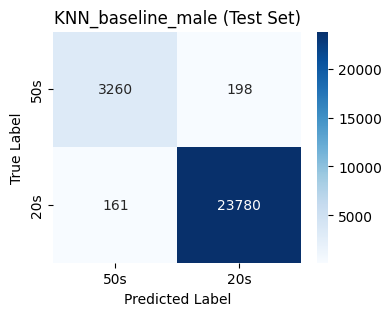


--- Test results for KNN_selectK_male ---
              precision    recall  f1-score   support

         50s     0.9488    0.9387    0.9437      3458
         20s     0.9912    0.9927    0.9919     23941

    accuracy                         0.9859     27399
   macro avg     0.9700    0.9657    0.9678     27399
weighted avg     0.9858    0.9859    0.9858     27399



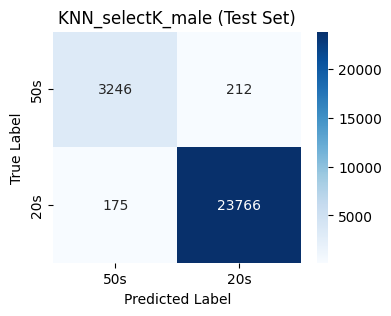


--- Test results for KNN_pca_male ---
              precision    recall  f1-score   support

         50s     0.9512    0.9407    0.9459      3458
         20s     0.9915    0.9930    0.9922     23941

    accuracy                         0.9864     27399
   macro avg     0.9713    0.9669    0.9691     27399
weighted avg     0.9864    0.9864    0.9864     27399



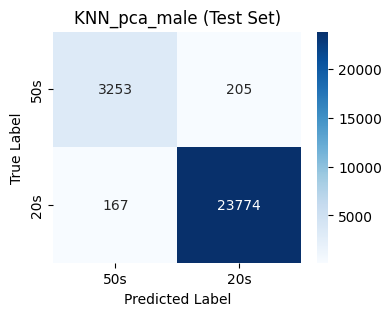

In [20]:
print("\n--- Evaluating Male Models on MALE Test Data ---")

# Make sure target names match your age encoding (e.g., 0='50s', 1='20s')
# Check your y variable's unique values and adjust if needed.
age_target_names = ['50s', '20s']
age_labels_numeric = sorted(np.unique(y_train_male_age)) # Get the actual numeric labels [0, 1]
if len(age_labels_numeric) != len(age_target_names):
    print(f"Warning: Mismatch between number of unique age labels ({len(age_labels_numeric)}) and target names ({len(age_target_names)}). Using numeric labels.")
    target_names_display = [str(l) for l in age_labels_numeric]
    xticklabels_display = [str(l) for l in age_labels_numeric]
    yticklabels_display = [str(l) for l in age_labels_numeric]

else:
     target_names_display = age_target_names
     xticklabels_display=age_target_names
     yticklabels_display=age_target_names



if not best_models_male:
     print("No models were successfully trained for males.")
elif X_test_male.shape[0] == 0:
     print("No test data available for males.")
else:
    for name, model in best_models_male.items():
        print(f"\n--- Test results for {name} ---")

        # Predict on the ORIGINAL male test data
        # The model pipeline handles scaling/pca/kbest transformation internally
        try:
            y_pred_male = model.predict(X_test_male)

            print(classification_report(
                y_test_male_age, y_pred_male,
                target_names=target_names_display,
                digits=4,
                zero_division=0 # Avoid warnings if a class has no test samples or predictions
            ))
            cm = confusion_matrix(y_test_male_age, y_pred_male, labels=age_labels_numeric) # Ensure labels match numeric order
            plt.figure(figsize=(4,3))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=xticklabels_display, yticklabels=yticklabels_display)
            plt.title(f"{name} (Test Set)")
            plt.xlabel('Predicted Label'); plt.ylabel('True Label')
            plt.show()
        except Exception as e:
            print(f"  ERROR during prediction or evaluation for {name}: {e}")

In [21]:
print(f"\n--- Splitting Female Data (Age) ---")
if len(X_female) > 0:
    can_stratify_female = len(np.unique(y_female_age)) > 1 and all(count >= 2 for count in pd.Series(y_female_age).value_counts())

    if not can_stratify_female:
        print("Warning: Cannot stratify female data by age (too few samples or only one class). Splitting without stratification.")
        stratify_param_female = None
    else:
        stratify_param_female = y_female_age

    X_train_female, X_test_female, y_train_female_age, y_test_female_age = train_test_split(
        X_female, y_female_age,
        test_size=TEST_SIZE,
        stratify=stratify_param_female,
        random_state=RANDOM_STATE
    )
    print("female Train shapes:", X_train_female.shape, y_train_female_age.shape)
    print("female Test shapes: ", X_test_female.shape, y_test_female_age.shape)
    print("female Train Age distribution:\n", pd.Series(y_train_female_age).value_counts(normalize=True))
    print("female Test Age distribution:\n", pd.Series(y_test_female_age).value_counts(normalize=True))
else:
    print("No female samples found to split.")
    X_train_female, X_test_female, y_train_female_age, y_test_female_age = [np.array([])]*4


--- Splitting Female Data (Age) ---
female Train shapes: (28132, 208) (28132,)
female Test shapes:  (7034, 208) (7034,)
female Train Age distribution:
 1    0.549979
0    0.450021
dtype: float64
female Test Age distribution:
 1    0.550043
0    0.449957
dtype: float64


In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, svd_solver='full')
X_train_female_pca = pca.fit_transform(X_train_female)
X_test_female_pca  = pca.transform(X_test_female)

In [ ]:
from sklearn.model_selection    import train_test_split, GridSearchCV
from sklearn.preprocessing      import StandardScaler
from sklearn.feature_selection  import SelectKBest, f_classif
from sklearn.decomposition      import PCA
from sklearn.pipeline           import Pipeline
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.metrics            import classification_report, confusion_matrix
import matplotlib.pyplot        as plt
import seaborn                  as sns

# 6) Define three pipelines
pipelines_female = {
    'KNN_baseline_female': Pipeline([
        ('scaler', StandardScaler()),
        ('knn',    KNeighborsClassifier())
    ]),
    'KNN_selectK_female': Pipeline([
        ('scaler', StandardScaler()),
        ('kbest',  SelectKBest(score_func=f_classif, k=min(100, X_train_female.shape[1] if X_train_female.ndim > 1 and X_train_female.shape[1] > 0 else 100))),
        ('knn',    KNeighborsClassifier())
    ]),
    'KNN_pca_female': Pipeline([
        ('scaler', StandardScaler()),
        ('pca',    PCA(n_components=0.95, svd_solver='full')),
        ('knn',    KNeighborsClassifier())
    ]),
}

param_grid_female = {
    'knn__n_neighbors': [3, 5, 7, 9]
}

best_models_female = {}
print("--- Training Models on female Data ---")

if X_train_female.shape[0] < 5:
    print(f"Skipping female model training: Insufficient training samples ({X_train_female.shape[0]})")
elif len(np.unique(y_train_female_age)) < 2:
     print(f"Skipping female model training: Only one class present in y_train_female_age.")
else:
    for name, pipe in pipelines_female.items():
        print(f"\n=== Tuning {name} ===")

        n_splits = min(3, min(np.unique(y_train_female_age, return_counts=True)[1]))
        if n_splits < 2:
            print(f"  Cannot perform cross-validation with n_splits={n_splits}. Skipping tuning for {name}.")
            continue

        grid = GridSearchCV(pipe, param_grid_female, cv=n_splits, n_jobs=-1, verbose=1, scoring='accuracy')

        try:
            grid.fit(X_train_female, y_train_female_age)
            print("  Best k:", grid.best_params_['knn__n_neighbors'],
                  "| CV acc:", f"{grid.best_score_:.4f}")
            best_models_female[name] = grid.best_estimator_
        except ValueError as e:
             print(f"  ERROR during GridSearchCV for {name}: {e}")
             print(f"  Skipping this pipeline. Check data dimensionality, KBest k value, or PCA components.")

--- Training Models on female Data ---

=== Tuning KNN_baseline_female ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
  Best k: 3 | CV acc: 0.9710

=== Tuning KNN_selectK_female ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
  Best k: 3 | CV acc: 0.9670

=== Tuning KNN_pca_female ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
  Best k: 3 | CV acc: 0.9708



--- Evaluating female Models on female Test Data ---

--- Test results for KNN_baseline_female ---
              precision    recall  f1-score   support

         50s     0.9639    0.9788    0.9713      3165
         20s     0.9825    0.9700    0.9762      3869

    accuracy                         0.9740      7034
   macro avg     0.9732    0.9744    0.9738      7034
weighted avg     0.9741    0.9740    0.9740      7034



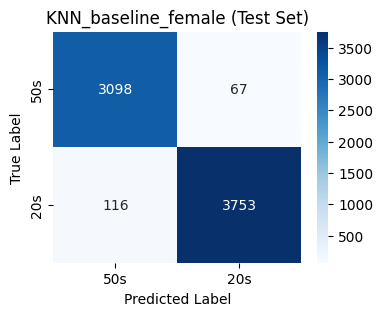


--- Test results for KNN_selectK_female ---
              precision    recall  f1-score   support

         50s     0.9653    0.9744    0.9698      3165
         20s     0.9789    0.9713    0.9751      3869

    accuracy                         0.9727      7034
   macro avg     0.9721    0.9729    0.9725      7034
weighted avg     0.9728    0.9727    0.9727      7034



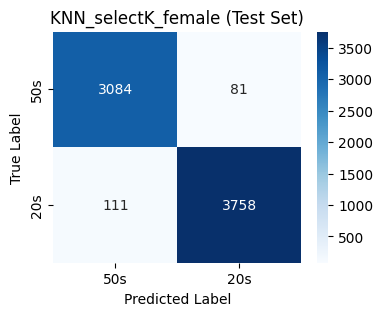


--- Test results for KNN_pca_female ---
              precision    recall  f1-score   support

         50s     0.9654    0.9779    0.9716      3165
         20s     0.9817    0.9713    0.9765      3869

    accuracy                         0.9743      7034
   macro avg     0.9735    0.9746    0.9740      7034
weighted avg     0.9744    0.9743    0.9743      7034



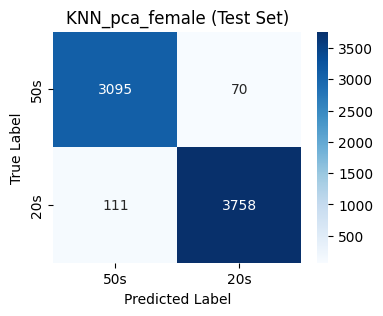

In [24]:
print("\n--- Evaluating female Models on female Test Data ---")

age_target_names = ['50s', '20s']
age_labels_numeric = sorted(np.unique(y_train_female_age))
if len(age_labels_numeric) != len(age_target_names):
    print(f"Warning: Mismatch between number of unique age labels ({len(age_labels_numeric)}) and target names ({len(age_target_names)}). Using numeric labels.")
    target_names_display = [str(l) for l in age_labels_numeric]
    xticklabels_display = [str(l) for l in age_labels_numeric]
    yticklabels_display = [str(l) for l in age_labels_numeric]
else:
     target_names_display = age_target_names
     xticklabels_display=age_target_names
     yticklabels_display=age_target_names

if not best_models_female:
     print("No models were successfully trained for females.")
elif X_test_female.shape[0] == 0:
     print("No test data available for females.")
else:
    for name, model in best_models_female.items():
        print(f"\n--- Test results for {name} ---")

        try:
            y_pred_female = model.predict(X_test_female)

            print(classification_report(
                y_test_female_age, y_pred_female,
                target_names=target_names_display,
                digits=4,
                zero_division=0
            ))
            cm = confusion_matrix(y_test_female_age, y_pred_female, labels=age_labels_numeric)
            plt.figure(figsize=(4,3))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=xticklabels_display, yticklabels=yticklabels_display)
            plt.title(f"{name} (Test Set)")
            plt.xlabel('Predicted Label'); plt.ylabel('True Label')
            plt.show()
        except Exception as e:
            print(f"  ERROR during prediction or evaluation for {name}: {e}")

In [25]:
for name, pipe in pipelines_female.items():
    dump(best_models_female[name], f'female_{name}')

for name, pipe in pipelines_male.items():
    dump(best_models_male[name], f'male_{name}')